# **Data Mining Sysyem Development**

In [173]:
!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.1)


In [174]:
# Importing important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
%matplotlib inline 
from sklearn.model_selection import train_test_split
import time
# from sklearn.externals import joblib
# !pip install Recommenders
# import Recommenders as Recommenders
# import Evaluation as Evaluation


# **Getting and Loading music data**

In [175]:
# link to the songs got crashed so decided to use the csv version
# #Collected music data from the millions dataset

# triplets_file = 'https://static.turi.com/datasets/millionsong/10000.txt'
# songs_metadata_file = 'https://static.turi.com/datasets/millionsong/song_data.csv'

# # df1 = pd.read_table(triplets_file,header=None)
# # df1.columns = ['user_id', 'song_id', 'listen_count']

# # Reading song metadata from the songs metadatafile
# df2 =  pd.read_csv(songs_metadata_file)

# #Merge the two dataframes above to create input dataframe for recommender systems
# df = pd.merge(df1,df2.drop_duplicates(['song_id']), on="song_id", how="left")

# # create a new column of song that is combination of title and artist name
# df['song'] = df['title'].map(str) + " - " + df['artist_name']

In [176]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data Mining/CSVs/song_data.csv")

In [177]:
# saving my dataframe
# df.to_csv('music_dataset', encoding='utf-8', index=False)

# **Exploratory analysis**

In [178]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1116609 entries, 0 to 1116608
Data columns (total 6 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   user_id       1116609 non-null  object
 1   song_id       1116609 non-null  object
 2   listen_count  1116609 non-null  int64 
 3   title         1116609 non-null  object
 4   artist        1116609 non-null  object
 5   song          1116609 non-null  object
dtypes: int64(1), object(5)
memory usage: 51.1+ MB


,user_id,song_id,listen_count,title,artist,song
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Jack Johnson,The Cove - Jack Johnson
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Paco De Lucia,Entre Dos Aguas - Paco De Lucia
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Kanye West,Stronger - Kanye West
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,Jack Johnson,Constellations - Jack Johnson
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,Foo Fighters,Learn To Fly - Foo Fighters


In [179]:
df.isnull().any()
len(df)

1116609

In [180]:
# we take the first 60,000 songs

df = df.head(60000)

In [181]:
# Top 10 listened music
grp_song = df.groupby(['song']).agg({'listen_count': 'count'}).reset_index()
grouped_sum = grp_song['listen_count'].sum()
top_songs = grp_song.sort_values(['listen_count', 'song'], ascending = [0,1])
top_songs = top_songs.head(10)
top_songs

,song,listen_count
6798,Sehr kosmisch - Harmonia,317
8651,Undo - Björk,295
9402,You're The One - Dwight Yoakam,258
1977,Dog Days Are Over (Radio Edit) - Florence + Th...,251
6453,Revelry - Kings Of Leon,235
6786,Secrets - OneRepublic,222
3441,Horn Concerto No. 4 in E flat K495: II. Romanc...,214
2591,Fireflies - Charttraxx Karaoke,184
8426,Tive Sim - Cartola,183
2124,Drop The World - Lil Wayne / Eminem,159


Text(0.5, 1.0, 'Top 10 Listened songs')

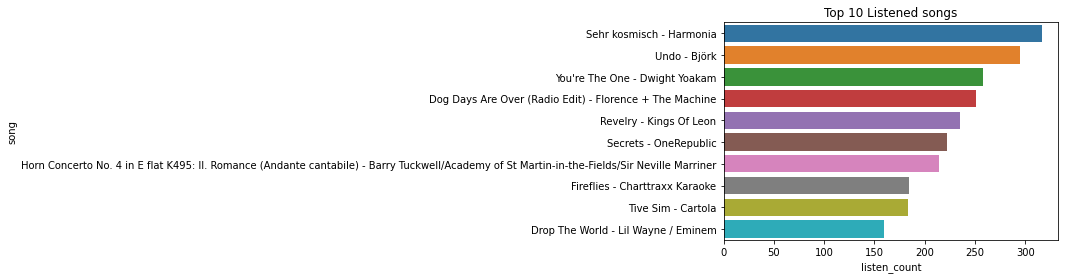

In [182]:
import seaborn as sns

sns.barplot(data=top_songs,x='listen_count', y='song')
plt.title('Top 10 Listened songs')
# sns.set(rc={'figure.figsize':(20,10)})

In [183]:
# count of unique users
users = df['user_id'].unique()
print("The number of unique users are",len(users))

# count of unique songs
songs = df['song_id'].unique()
print("The number of unique songs are",len(songs))

The number of unique users are 3574
The number of unique songs are 9508


# **Recommender System**

In [184]:


music=df.drop_duplicates(['user_id','song','title','artist'])
music=music.reset_index(drop=True)

In [185]:
len(music)

59960

In [186]:
music= music.iloc[0:50000,]
music.shape

(50000, 6)

In [187]:
music.head(10)

,user_id,song_id,listen_count,title,artist,song
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Jack Johnson,The Cove - Jack Johnson
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Paco De Lucia,Entre Dos Aguas - Paco De Lucia
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Kanye West,Stronger - Kanye West
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,Jack Johnson,Constellations - Jack Johnson
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,Foo Fighters,Learn To Fly - Foo Fighters
5,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODDNQT12A6D4F5F7E,5,Apuesta Por El Rock 'N' Roll,Héroes del Silencio,Apuesta Por El Rock 'N' Roll - Héroes del Sile...
6,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODXRTY12AB0180F3B,1,Paper Gangsta,Lady GaGa,Paper Gangsta - Lady GaGa
7,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOFGUAY12AB017B0A8,1,Stacked Actors,Foo Fighters,Stacked Actors - Foo Fighters
8,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOFRQTD12A81C233C0,1,Sehr kosmisch,Harmonia,Sehr kosmisch - Harmonia
9,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOHQWYZ12A6D4FA701,1,Heaven's gonna burn your eyes,Thievery Corporation feat. Emiliana Torrini,Heaven's gonna burn your eyes - Thievery Corpo...


In [188]:
# This is going to be the filtering table
music_pivot=music.pivot(index='user_id',columns='song_id',values='listen_count')
music_pivot=music_pivot.fillna(0)
music_pivot

song_id,SOAAAGQ12A8C1420C8,SOAACPJ12A81C21360,SOAACSG12AB018DC80,SOAAEJI12AB0188AB5,SOAAFAC12A67ADF7EB,SOAAFYH12A8C13717A,SOAAJMQ12A6D4F7D17,SOAAKPM12A58A77210,SOAALWN12A6D4F7FDA,SOAAMOW12AB018149B,SOAAOYI12AB01831CE,SOAAROC12A6D4FA420,SOAARXR12A8C133D15,SOAATHE12A8C13ADD6,SOAATLI12A8C13E319,SOAAUKC12AB017F868,SOAAVUV12AB0186646,SOAAWEE12A6D4FBEC8,SOABHNP12A8AE46E82,SOABHYV12A6D4F6D0F,SOABJBU12A8C13F63F,SOABJTC12A58A7DE0E,SOABNLP12A6D4F87F4,SOABNPW12A6D4FC9B5,SOABOHM12AB018509C,SOABOXV12AC3DF82F7,SOABPQU12A58A78441,SOABQTG12A6701F3DB,SOABRAB12A6D4F7AAF,SOABTTR12A6D4FC2EB,SOABXNE12A8C13B818,SOACBLB12AB01871C7,SOACDMD12A67AD8332,SOACERJ12A67AD865E,SOACGVR12A8C13B60A,SOACIPG12A8AE47E1C,SOACKIA12A6D4F73D7,SOACMJJ12A6D4FC66A,SOACNQJ12A8C13B09E,SOACPBY12A8C13FEF9,...,SOZWQWC12AF72AAA2C,SOZWQWL12A58A7EA09,SOZWTCZ12AF729F5E3,SOZWVZW12AF72A0E04,SOZWWTF12A8C1408E2,SOZXBIS12A8AE44A2E,SOZXBVL12AB0184D35,SOZXEZV12A6D4F737F,SOZXHNM12AB017CDEA,SOZXHYA12A8C145274,SOZXKIA12A6D4F861C,SOZXLPJ12A6701F7AB,SOZXMYX12AB018A445,SOZXNVK12A8C13CF0E,SOZXQHF12A58A79168,SOZXQRQ12A6701C323,SOZXSEC12A67020AB5,SOZXSYQ12AB0184F5F,SOZXTAI12A8C134DE1,SOZXTUT12A6D4F6D03,SOZXVWK12AB018B865,SOZYBGN12A8C13A93C,SOZYDZR12A8C13F4F0,SOZYIQR12A58A7DB25,SOZYNNT12A81C22E0F,SOZYSDT12A8C13BFD7,SOZYTWE12A3F1EA18B,SOZYUGZ12A8AE472AC,SOZYUXF12A6701F7B9,SOZZCXT12A6D4FA441,SOZZEID12A58A7AB89,SOZZHQT12AB018B714,SOZZIOH12A67ADE300,SOZZKPR12A6D4F8147,SOZZLZN12A8AE48D6D,SOZZRHE12A6702165F,SOZZTCU12AB0182C58,SOZZTNF12A8C139916,SOZZVWB12AB0189C30,SOZZWZV12A67AE140F
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0007c0e74728ca9ef0fe4eb7f75732e8026a278b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0039bd8483d578997718cdc0bf6c7c88b679f488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00498f4bab2bfeb17680113c7d9525ad5b0ad401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
006edf2afa5cba7e65ccc97892021a129d7012dd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0085231435fa2ec76642d0ad79070239fa023347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffa24617ea80c268c74e86cd3ee3d9e7ac5504ec,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0

In [189]:
music_pivot.shape
music_pivot.shape[0]

2952

In [190]:
music_pivot[music_pivot.SOBYHAJ12A6701BF1D==1]

song_id,SOAAAGQ12A8C1420C8,SOAACPJ12A81C21360,SOAACSG12AB018DC80,SOAAEJI12AB0188AB5,SOAAFAC12A67ADF7EB,SOAAFYH12A8C13717A,SOAAJMQ12A6D4F7D17,SOAAKPM12A58A77210,SOAALWN12A6D4F7FDA,SOAAMOW12AB018149B,SOAAOYI12AB01831CE,SOAAROC12A6D4FA420,SOAARXR12A8C133D15,SOAATHE12A8C13ADD6,SOAATLI12A8C13E319,SOAAUKC12AB017F868,SOAAVUV12AB0186646,SOAAWEE12A6D4FBEC8,SOABHNP12A8AE46E82,SOABHYV12A6D4F6D0F,SOABJBU12A8C13F63F,SOABJTC12A58A7DE0E,SOABNLP12A6D4F87F4,SOABNPW12A6D4FC9B5,SOABOHM12AB018509C,SOABOXV12AC3DF82F7,SOABPQU12A58A78441,SOABQTG12A6701F3DB,SOABRAB12A6D4F7AAF,SOABTTR12A6D4FC2EB,SOABXNE12A8C13B818,SOACBLB12AB01871C7,SOACDMD12A67AD8332,SOACERJ12A67AD865E,SOACGVR12A8C13B60A,SOACIPG12A8AE47E1C,SOACKIA12A6D4F73D7,SOACMJJ12A6D4FC66A,SOACNQJ12A8C13B09E,SOACPBY12A8C13FEF9,...,SOZWQWC12AF72AAA2C,SOZWQWL12A58A7EA09,SOZWTCZ12AF729F5E3,SOZWVZW12AF72A0E04,SOZWWTF12A8C1408E2,SOZXBIS12A8AE44A2E,SOZXBVL12AB0184D35,SOZXEZV12A6D4F737F,SOZXHNM12AB017CDEA,SOZXHYA12A8C145274,SOZXKIA12A6D4F861C,SOZXLPJ12A6701F7AB,SOZXMYX12AB018A445,SOZXNVK12A8C13CF0E,SOZXQHF12A58A79168,SOZXQRQ12A6701C323,SOZXSEC12A67020AB5,SOZXSYQ12AB0184F5F,SOZXTAI12A8C134DE1,SOZXTUT12A6D4F6D03,SOZXVWK12AB018B865,SOZYBGN12A8C13A93C,SOZYDZR12A8C13F4F0,SOZYIQR12A58A7DB25,SOZYNNT12A81C22E0F,SOZYSDT12A8C13BFD7,SOZYTWE12A3F1EA18B,SOZYUGZ12A8AE472AC,SOZYUXF12A6701F7B9,SOZZCXT12A6D4FA441,SOZZEID12A58A7AB89,SOZZHQT12AB018B714,SOZZIOH12A67ADE300,SOZZKPR12A6D4F8147,SOZZLZN12A8AE48D6D,SOZZRHE12A6702165F,SOZZTCU12AB0182C58,SOZZTNF12A8C139916,SOZZVWB12AB0189C30,SOZZWZV12A67AE140F
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1645b689f873529ab85e3b72742be44813e82bd3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2a8a8f48fd4eb5ca4b64874162df4fdf584d89c4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33280fc74b168e2667a2da5c6ab4df4cc6edfb23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
572da9d6331782b8c48924968f0778a331170c20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6f8453b0d9d2199f98c1992995a8445ad6837fd8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7a4b8e7d2905d13422418b4f48cc85100892e013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7ff09036b3ba258b13621875d18d43511ed2e09c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

Train a Knn model using Music Pivot_Table

In [191]:
from sklearn.neighbors import NearestNeighbors
knn=NearestNeighbors(n_neighbors=10,metric='cosine')
Model=knn.fit(music_pivot)

In [192]:
music_pivot[music_pivot.index==1]
music_pivot.shape[0]
music_pivot.dtypes

song_id
SOAAAGQ12A8C1420C8    float64
SOAACPJ12A81C21360    float64
SOAACSG12AB018DC80    float64
SOAAEJI12AB0188AB5    float64
SOAAFAC12A67ADF7EB    float64
                       ...   
SOZZRHE12A6702165F    float64
SOZZTCU12AB0182C58    float64
SOZZTNF12A8C139916    float64
SOZZVWB12AB0189C30    float64
SOZZWZV12A67AE140F    float64
Length: 9242, dtype: object

In [193]:
# users are from 0-2591
user = music_pivot.iloc[10]
user.astype(float)

song_id
SOAAAGQ12A8C1420C8    0.0
SOAACPJ12A81C21360    0.0
SOAACSG12AB018DC80    0.0
SOAAEJI12AB0188AB5    0.0
SOAAFAC12A67ADF7EB    0.0
                     ... 
SOZZRHE12A6702165F    0.0
SOZZTCU12AB0182C58    0.0
SOZZTNF12A8C139916    0.0
SOZZVWB12AB0189C30    0.0
SOZZWZV12A67AE140F    0.0
Name: 00f51c1ca1385bbfd80de6fe313936e69cde7f41, Length: 9242, dtype: float64

In [194]:
music_pivot.iloc[10].astype(int)

song_id
SOAAAGQ12A8C1420C8    0
SOAACPJ12A81C21360    0
SOAACSG12AB018DC80    0
SOAAEJI12AB0188AB5    0
SOAAFAC12A67ADF7EB    0
                     ..
SOZZRHE12A6702165F    0
SOZZTCU12AB0182C58    0
SOZZTNF12A8C139916    0
SOZZVWB12AB0189C30    0
SOZZWZV12A67AE140F    0
Name: 00f51c1ca1385bbfd80de6fe313936e69cde7f41, Length: 9242, dtype: int64

In [195]:
distances, indices = Model.kneighbors([user])
distances, indices

(array([[2.22044605e-16, 5.05720617e-01, 8.11421428e-01, 8.49576337e-01,
         8.61057496e-01, 8.69729286e-01, 8.70031189e-01, 8.73684068e-01,
         8.78803459e-01, 8.80498300e-01]]),
 array([[  10, 1315, 1936,  386,  848,  928, 1437, 1116, 1490, 2431]]))

In [196]:
# The indices contains only the index values of users from the user table.
#  It doesnt show user_id. We've to find out user_id of neighbors

neighbors=[]
for item in indices[0][1:]:
    neighbors.append(music[music.index == item].user_id.values[0])
neighbors

['eb9d84c10ac4bffeb383a3a7c2d5207c93da4a84',
 'e0388a836f13f4c1f8aa600ae61625f087f40353',
 'ee03697dfdf668a9cd19a44a6f257b9d6a1dc60a',
 'f28f980d8842ebfaa31e8fb3939aace4a43a18ec',
 '3b3c1e29095a98ae07e2427522244f10daa69340',
 '8ee90038724c4957eb4df16f3e9c6ed2b570a3ec',
 '589d9f98cb25b83da2450733437fb9a79dda116d',
 '881f2e87fe2a45ae27d6e235c156c762ac3cb82a',
 '956999576244ad42d6d41faac8505fbef0a4ccc1']

In [197]:
# Make a dataframe with details of only the neighbors.

neighbor_songs=pd.DataFrame(columns=['user_id','song_id','listen_count','title','artist','song'])
for item in neighbors:
    neighbor_songs=neighbor_songs.append(music[music.user_id == item],ignore_index = True)
neighbor_songs

,user_id,song_id,listen_count,title,artist,song
0,eb9d84c10ac4bffeb383a3a7c2d5207c93da4a84,SOBJDVT12A6701E079,6,Woman In Chains,Tears For Fears / Oleta Adams,Woman In Chains - Tears For Fears / Oleta Adams
1,eb9d84c10ac4bffeb383a3a7c2d5207c93da4a84,SOBYZRW12A58A7ABF1,2,Head Over Heels,Tears For Fears,Head Over Heels - Tears For Fears
2,eb9d84c10ac4bffeb383a3a7c2d5207c93da4a84,SOCHPLU12A8C13462D,1,Me_ Myself And I,Beyoncé,Me_ Myself And I - Beyoncé
3,eb9d84c10ac4bffeb383a3a7c2d5207c93da4a84,SODJQUS12A6701D1D3,1,With A Little Help From My Friends,Joe Cocker,With A Little Help From My Friends - Joe Cocker
4,eb9d84c10ac4bffeb383a3a7c2d5207c93da4a84,SOHCUMK12A8C14078A,2,Oh What A Night,The Dells,Oh What A Night - The Dells
...,...,...,...,...,...,...
175,956999576244ad42d6d41faac8505fbef0a4ccc1,SOWKBNB12A582A2325,5,Paris (Acoustic),Claw Boys Claw,Paris (Acoustic) - Claw Boys Claw
176,956999576244ad42d6d41faac8505fbef0a4ccc1,SOWLHIM12A6D4FB67A,4,The Voice,Celtic Woman,The Voice - Celtic Woman
177,956999576244ad42d6d41faac8505fbef0a4ccc1,SOWMRSY12A8C140AA3,5,Unbreakable,Fireflight,Unbreakable - Fireflight
178,956999576244ad42d6d41faac8505fbef0a4ccc1,SOXXACF12A6D4F953E,1,End,Secondhand Serenade,End - Secondhand Serenade


In [198]:
neighbor_songs=pd.DataFrame({'Count':neighbor_songs['listen_count'],'Song':neighbor_songs.song.tolist()})

In [199]:
neighbor_songs

,Count,Song
0,6,Woman In Chains - Tears For Fears / Oleta Adams
1,2,Head Over Heels - Tears For Fears
2,1,Me_ Myself And I - Beyoncé
3,1,With A Little Help From My Friends - Joe Cocker
4,2,Oh What A Night - The Dells
...,...,...
175,5,Paris (Acoustic) - Claw Boys Claw
176,4,The Voice - Celtic Woman
177,5,Unbreakable - Fireflight
178,1,End - Secondhand Serenade


In [200]:
neighbor_songs=neighbor_songs.sort_values('Count',ascending=False)
neighbor_songs

,Count,Song
48,17,You're A Cad - the bird and the bee
139,14,Dirty World - Traveling Wilburys
164,11,Do We Need This? - Muse
83,10,Who Knows Who Cares - Local Natives
173,9,Lacrymosa - Evanescence
...,...,...
70,1,It's Christmas So We'll Stop (Choir Version) -...
69,1,Le Moulin - Yann Tiersen
68,1,Alpha Beta Gaga - Air
67,1,Mayday!!! - Flobots


In [201]:
neighbor_songs=neighbor_songs.reset_index(drop=True)
neighbor_songs

,Count,Song
0,17,You're A Cad - the bird and the bee
1,14,Dirty World - Traveling Wilburys
2,11,Do We Need This? - Muse
3,10,Who Knows Who Cares - Local Natives
4,9,Lacrymosa - Evanescence
...,...,...
175,1,It's Christmas So We'll Stop (Choir Version) -...
176,1,Le Moulin - Yann Tiersen
177,1,Alpha Beta Gaga - Air
178,1,Mayday!!! - Flobots


In [202]:
Recommended_Song=neighbor_songs['Song'][0:10]
print(Recommended_Song)

0                  You're A Cad - the bird and the bee
1                     Dirty World - Traveling Wilburys
2                              Do We Need This? - Muse
3                  Who Knows Who Cares - Local Natives
4                              Lacrymosa - Evanescence
5                            Wide Eyes - Local Natives
6                               Adrenalin - Eisbrecher
7                                     Rain - Subhumans
8    A Beggar On A Beach Of Gold - Mike And The Mec...
9      Woman In Chains - Tears For Fears / Oleta Adams
Name: Song, dtype: object


In [203]:
len(neighbor_songs)

180

In [204]:
import pickle

In [205]:
pickle.dump(Model, open("algo.pkl", "wb"))

In [206]:
music.to_pickle('music.csv')
music_pivot.to_pickle('music_pivot.csv')